In [ ]:
import tensorflow as tf
import os
import json
import pandas as pd
import re
import numpy as np
import time
import matplotlib.pyplot as plt
import collections
import random
import requests
import json
from math import sqrt
from PIL import Image
from tqdm.auto import tqdm
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from tensorflow.keras import layers


In [ ]:
BASE_PATH = "C:/Users/IDAC PC/Desktop/UtkuThesis/ImageCaptioning/datasets/coco2017"

In [ ]:
with open(f'{BASE_PATH}/annotations/captions_train2017.json', 'r') as f:
    data = json.load(f)
    data = data['annotations']

img_cap_pairs = []

for sample in data:
    img_name = '%012d.jpg' % sample['image_id']
    img_cap_pairs.append([img_name, sample['caption']])

captions = pd.DataFrame(img_cap_pairs, columns=['image', 'caption'])
captions['image'] = captions['image'].apply(
    lambda x: f'{BASE_PATH}/train2017/{x}'
)
captions = captions.sample(70000)
captions = captions.reset_index(drop=True)
captions.head()

In [ ]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip()
    text = '[start] ' + text + ' [end]'
    return text

In [ ]:
captions['caption'] = captions['caption'].apply(preprocess)
captions.head()

In [ ]:
#for training tests only
#captions = captions.iloc[0:10000]
captions.shape

In [ ]:
random_row = captions.sample(1).iloc[0]
print(random_row.caption)
im = Image.open(random_row.image)
im

In [ ]:
MAX_LENGTH = 40
VOCABULARY_SIZE = 25000
BATCH_SIZE = 32
BUFFER_SIZE = 1000
EMBEDDING_DIM = 512
DENSE_DIM = 2048
UNITS = 512
EPOCHS = 25


In [ ]:
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCABULARY_SIZE,
    standardize=None,
    output_sequence_length=MAX_LENGTH)

tokenizer.adapt(captions['caption'])

In [114]:
tokenizer.vocabulary_size()

11827

In [ ]:
import pickle

pickle.dump(tokenizer.get_vocabulary(), open('vocab_coco.file', 'wb'))

In [ ]:
word2idx = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())

idx2word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [ ]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(captions['image'], captions['caption']):
    img_to_cap_vector[img].append(cap)

img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = (img_keys[:slice_index], 
                                          img_keys[slice_index:])

train_imgs = []
train_captions = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    train_imgs.extend([imgt] * capt_len)
    train_captions.extend(img_to_cap_vector[imgt])

val_imgs = []
val_captions = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    val_imgs.extend([imgv] * capv_len)
    val_captions.extend(img_to_cap_vector[imgv])

In [115]:
len(train_imgs), len(train_captions), len(val_imgs), len(val_captions)

(55944, 55944, 14056, 14056)

In [ ]:
def load_data(img_path, caption):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    caption = tokenizer(caption)
    return img, caption
image_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomContrast(0.3),
    ]
)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_imgs, train_captions))

train_dataset = train_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_imgs, val_captions))

val_dataset = val_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def CNN_Encoder():
    inception_v3 = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet'
    )

    output = inception_v3.output
    output = tf.keras.layers.Reshape(
        (-1, output.shape[-1]))(output)

    cnn_model = tf.keras.models.Model(inception_v3.input, output)
    return cnn_model

In [189]:
import tensorflow as tf
from tensorflow.keras import layers

class Embeddings(tf.keras.layers.Layer):

    def __init__(self, vocab_size, embed_dim, max_len):
        super().__init__()
        self.token_embeddings = tf.keras.layers.Embedding(
            vocab_size, embed_dim)
        self.position_embeddings = tf.keras.layers.Embedding(
            max_len, embed_dim, input_shape=(None, max_len))
    

    def call(self, input_ids):
        length = tf.shape(input_ids)[-1]
        position_ids = tf.range(start=0, limit=length, delta=1)
        position_ids = tf.expand_dims(position_ids, axis=0)

        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)

        return token_embeddings + position_embeddings

class MultiheadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super(MultiheadAttention, self).__init__()
        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=d_model // num_heads, dropout=dropout
        )
        self.dropout = layers.Dropout(dropout)

    def call(self, inputs, mask=None):
        output = self.attention(inputs, inputs, attention_mask=mask)
        output = self.dropout(output, training=self.training)
        return output


class PositionwiseFeedforward(tf.keras.layers.Layer):
    def __init__(self, d_model, dim_feedforward, dropout=0.1, activation="relu"):
        super(PositionwiseFeedforward, self).__init__()
        self.linear1 = layers.Dense(dim_feedforward, activation=activation)
        self.dropout = layers.Dropout(dropout)
        self.linear2 = layers.Dense(d_model)

    def call(self, inputs):
        x = self.linear1(inputs)
        x = self.dropout(x, training=self.training)
        x = self.linear2(x)
        return x

#def __init__(self, embed_dim, dense_dim, num_heads, dropout_rate=0.1, l2_reg=1e-4, **kwargs):
class TransformerEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dim_feedforward=2048, dropout=0.1, activation="relu"):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = MultiheadAttention(d_model, num_heads, dropout)
        self.feedforward = PositionwiseFeedforward(d_model, dim_feedforward, dropout, activation)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout)
        self.dropout2 = layers.Dropout(dropout)
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, mask=None):
        attn_output = self.self_attn(inputs, mask=mask)
        out1 = inputs + self.dropout1(attn_output, training=self.training)
        norm1_output = self.norm1(out1)
        ff_output = self.feedforward(norm1_output)
        out2 = out1 + self.dropout2(ff_output, training=self.training)
        output = self.norm2(out2)
        return output


class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dim_feedforward=2048, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        self.layers = [TransformerEncoderLayer(d_model, num_heads, dim_feedforward, dropout) for _ in range(num_layers)]
        self.norm = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs, mask=None):
        output = inputs
        for layer in self.layers:
            output = layer(output, mask=mask)
        output = self.norm(output)
        return output


class TransformerDecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dim_feedforward=2048, dropout=0.1, activation="relu"):
        super(TransformerDecoderLayer, self).__init__()
        self.self_attn = MultiheadAttention(d_model, num_heads, dropout)
        self.multihead_attn = MultiheadAttention(d_model, num_heads, dropout)
        self.feedforward = PositionwiseFeedforward(d_model, dim_feedforward, dropout, activation)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.norm3 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout)
        self.dropout2 = layers.Dropout(dropout)
        self.dropout3 = layers.Dropout(dropout)
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, memory, tgt_mask=None, memory_mask=None):
        attn_output1 = self.self_attn(inputs, mask=tgt_mask)
        out1 = inputs + self.dropout1(attn_output1, training=self.training)
        norm1_output = self.norm1(out1)

        attn_output2 = self.multihead_attn(norm1_output, memory, mask=memory_mask)
        out2 = norm1_output + self.dropout2(attn_output2, training=self.training)
        norm2_output = self.norm2(out2)

        ff_output = self.feedforward(norm2_output)
        out3 = norm2_output + self.dropout3(ff_output, training=self.training)
        output = self.norm3(out3)

        return output


class TransformerDecoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dim_feedforward=2048, dropout=0.1):
        super(TransformerDecoder, self).__init__()
        self.layers = [TransformerDecoderLayer(d_model, num_heads, dim_feedforward, dropout) for _ in range(num_layers)]
        self.norm = layers.LayerNormalization(epsilon=1e-6)

    def call(self, tgt, memory, tgt_mask=None, memory_mask=None):
        output = tgt
        for layer in self.layers:
            output = layer(output, memory, tgt_mask=tgt_mask, memory_mask=memory_mask)
        output = self.norm(output)
        return output


class Transformer(tf.keras.Model):
    def __init__(self, d_model=512, num_heads=8, num_encoder_layers=6,
                 num_decoder_layers=6, dim_feedforward=2048, dropout=0.1,
                 activation="relu", normalize_before=False):
        super(Transformer, self).__init__()

        self.encoder = TransformerEncoder(num_encoder_layers, d_model, num_heads, dim_feedforward, dropout)
        self.decoder = TransformerDecoder(num_decoder_layers, d_model, num_heads, dim_feedforward, dropout)
        self._reset_parameters()

    def _reset_parameters(self):
        for layer in self.layers:
            if hasattr(layer, 'kernel_initializer') and hasattr(layer.kernel_initializer, 'call'):
                layer.kernel_initializer = layer.kernel_initializer.call()
            if hasattr(layer, 'bias_initializer') and hasattr(layer.bias_initializer, 'call'):
                layer.bias_initializer = layer.bias_initializer.call()

    def call(self, src, mask, query_embed, pos_embed):
        bs, c, h, w = tf.shape(src)
        src = tf.transpose(tf.reshape(src, (bs, c, -1)), perm=(0, 2, 1))
        pos_embed = tf.transpose(tf.reshape(pos_embed, (bs, c, -1)), perm=(0, 2, 1))
        query_embed = tf.tile(tf.expand_dims(query_embed, axis=1), multiples=[1, bs, 1])
        mask = tf.reshape(mask, (bs, -1))

        tgt = tf.zeros_like(query_embed)
        memory = self.encoder(src, mask=mask)
        hs = self.decoder(tgt, memory, tgt_mask=None, memory_mask=None)
        return tf.transpose(hs, perm=(0, 2, 1)), tf.reshape(tf.transpose(memory, perm=(0, 2, 1)), (bs, c, h, w))


def build_transformer(args):
    return Transformer(
        d_model=args.hidden_dim,
        dropout=args.dropout,
        num_heads=args.nheads,
        dim_feedforward=args.dim_feedforward,
        num_encoder_layers=args.enc_layers,
        num_decoder_layers=args.dec_layers,
        normalize_before=args.pre_norm,
    )


In [ ]:
import tensorflow as tf

class Attention(tf.keras.layers.Layer):
    def __init__(self, num_heads, embed_dim, key_dim=None, dropout=0.1, l2_reg=1e-4, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.head_dim = embed_dim // num_heads
        self.query_dense = tf.keras.layers.Dense(embed_dim, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))
        self.key_dense = tf.keras.layers.Dense(key_dim if key_dim is not None else embed_dim, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))
        self.value_dense = tf.keras.layers.Dense(embed_dim, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))
        self.dropout_layer = tf.keras.layers.Dropout(dropout)
        self.concat_heads = tf.keras.layers.Concatenate(axis=-1)
        self.combine_heads = tf.keras.layers.Dense(embed_dim, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))

    def call(self, inputs, training=None):
        query, key, value, attention_mask = inputs

        # Apply dense layers
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # Split the heads
        query = self.split_heads(query)
        key = self.split_heads(key)
        value = self.split_heads(value)

        # Scaled dot-product attention
        scaled_attention = self.scaled_dot_product_attention(query, key, value, attention_mask)

        # Combine heads
        scaled_attention = self.combine_heads(scaled_attention)

        # Final linear layer
        attention_output = self.dropout_layer(scaled_attention, training=training)
        return attention_output

    def scaled_dot_product_attention(self, query, key, value, attention_mask):
        matmul_qk = tf.matmul(query, key, transpose_b=True)

        # Scale matmul_qk
        depth = tf.cast(tf.shape(key)[-1], tf.float32)
        logits = matmul_qk / tf.math.sqrt(depth)

        # Add the mask to zero out padding tokens
        if attention_mask is not None:
            logits += (attention_mask * -1e9)

        # Apply softmax
        attention_weights = tf.nn.softmax(logits, axis=-1)

        # Apply dropout
        attention_weights = self.dropout_layer(attention_weights)

        output = tf.matmul(attention_weights, value)
        output = self.concat_heads(output)
        output = self.combine_heads(output)

        return output

    def split_heads(self, x):
        batch_size = tf.shape(x)[0]
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.head_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])


In [117]:
class TransformerEncoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, dense_dim, num_heads, dropout_rate=0.2, l2_reg=1e-4, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.l2_reg = l2_reg

        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=dropout_rate,
            
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=dropout_rate,
            
        )
        self.attention_3 =layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=dropout_rate,
            
        )
        self.attention_4 =layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=dropout_rate,
           
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l2_reg))
        self.dense_2 = layers.Dense(embed_dim, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l2_reg))
        self.dense_3 = layers.Dense(embed_dim, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l2_reg))
        self.dropout = layers.Dropout(dropout_rate)

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)
        inputs = self.dense_2(inputs)
        inputs = self.dense_3(inputs)
        inputs = self.dropout(inputs, training=training)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )

        out_1 = self.layernorm_2(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=out_1,
            key=out_1,
            attention_mask=None,
            training=training,
        )

        out_2 = self.layernorm_2(out_1 + attention_output_2)

        attention_output_3 = self.attention_3(
            query=out_2, value=out_2, key=out_2, attention_mask=None, training=training,
        )

        out_3 = out_2 + attention_output_3

        attention_output_4 = self.attention_4(
            query=out_3, value=out_3, key=out_3, attention_mask=None, training=training,
        )

        out_4 = out_3 + attention_output_4

        return out_4

In [ ]:
class Embeddings(tf.keras.layers.Layer):

    def __init__(self, vocab_size, embed_dim, max_len):
        super().__init__()
        self.token_embeddings = tf.keras.layers.Embedding(
            vocab_size, embed_dim)
        self.position_embeddings = tf.keras.layers.Embedding(
            max_len, embed_dim, input_shape=(None, max_len))
    

    def call(self, input_ids):
        length = tf.shape(input_ids)[-1]
        position_ids = tf.range(start=0, limit=length, delta=1)
        position_ids = tf.expand_dims(position_ids, axis=0)

        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)

        return token_embeddings + position_embeddings
   

In [125]:
class TransformerDecoderLayer(tf.keras.layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, dropout_rate1=0.3, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        

        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=dropout_rate1,kernel_regularizer=tf.keras.regularizers.l2(1e-4))
        self.attention_2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=dropout_rate1,kernel_regularizer=tf.keras.regularizers.l2(1e-4))
        self.attention_3 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=dropout_rate1,kernel_regularizer=tf.keras.regularizers.l2(1e-4))
        self.attention_4 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=dropout_rate1,kernel_regularizer=tf.keras.regularizers.l2(1e-4))
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(1e-4))
        self.ffn_layer_2 = layers.Dense(embed_dim, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(1e-4))
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.layernorm_4 = layers.LayerNormalization()
        self.embedding = Embeddings(tokenizer.vocabulary_size(), embed_dim, MAX_LENGTH)
        self.out = tf.keras.layers.Dense(tokenizer.vocabulary_size(), activation="softmax")
        self.dropout_1 = layers.Dropout(dropout_rate1)
        self.dropout_2 = layers.Dropout(dropout_rate1)
        self.dropout_3 = layers.Dropout(dropout_rate1)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=out_1,
            key=out_1,
            attention_mask=combined_mask,
            training=training,
        )

        out_2 = self.layernorm_2(out_1 + attention_output_2)

        attention_output_3 = self.attention_3(
            query=out_2, value=out_2, key=out_2, attention_mask=combined_mask, training=training,
        )

        out_3 = self.layernorm_3(out_2 + attention_output_3)

        attention_output_4 = self.attention_4(
            query=out_3, value=out_3, key=out_3, attention_mask=combined_mask, training=training,
        )

        out_4 = self.layernorm_4(out_3 + attention_output_4)

        ffn_out = self.ffn_layer_1(out_4)
        ffn_out = self.dropout_1(ffn_out, training=training)

        ffn_out = self.ffn_layer_2(ffn_out)
        ffn_out = self.dropout_2(ffn_out, training=training)

        ffn_out = self.layernorm_4(ffn_out + out_4, training=training)

        preds = self.out(ffn_out)

        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]

        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype=tf.int32)

        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))

        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

In [ ]:
class ImageCaptioningModel(tf.keras.Model):

    def __init__(self, cnn_model, encoder, decoder, image_aug=None):
        super().__init__()
        self.cnn_model = cnn_model
        
        self.encoder = encoder
        self.decoder = decoder
        self.image_aug = image_aug
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker = tf.keras.metrics.Mean(name="accuracy")


    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)


    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)
    

    def compute_loss_and_acc(self, img_embed, captions, training=True):
        encoder_output = self.encoder(img_embed, training=True)
        y_input = captions[:, :-1]
        y_true = captions[:, 1:]
        mask = (y_true != 0)
        y_pred = self.decoder(
            y_input, encoder_output, training=True, mask=mask
        )
        loss = self.calculate_loss(y_true, y_pred, mask)
        acc = self.calculate_accuracy(y_true, y_pred, mask)
        return loss, acc

    
    def train_step(self, batch):
        imgs, captions = batch

        if self.image_aug:
            imgs = self.image_aug(imgs)
        
        img_embed = self.cnn_model(imgs)

        with tf.GradientTape() as tape:
            loss, acc = self.compute_loss_and_acc(
                img_embed, captions
            )
    
        train_vars = (
            self.encoder.trainable_variables + self.decoder.trainable_variables
        )
        grads = tape.gradient(loss, train_vars)
        self.optimizer.apply_gradients(zip(grads, train_vars))
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}
    

    def test_step(self, batch):
        imgs, captions = batch

        img_embed = self.cnn_model(imgs)

        loss, acc = self.compute_loss_and_acc(
            img_embed, captions, training=False
        )

        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]

In [ ]:
MAX_LENGTH = 50
VOCABULARY_SIZE = 25000
BATCH_SIZE = 64
BUFFER_SIZE = 1000
EMBEDDING_DIM = 512
UNITS = 512
EPOCHS = 20

In [126]:
encoder = TransformerEncoderLayer(EMBEDDING_DIM, 1, num_heads=6)
decoder = TransformerDecoderLayer(EMBEDDING_DIM, UNITS, 8 )

cnn_model = CNN_Encoder()
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

In [ ]:
class TransformerEncoderDETR(tf.keras.layers.Layer):

    def __init__(self, embed_dim, dense_dim, num_heads, dropout_rate=0.1, l2_reg=1e-6, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.l2_reg = l2_reg

        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=dropout_rate,)
        
        self.dense_1 = layers.Dense(embed_dim, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l2_reg))

        self.dropout_1 = layers.Dropout(dropout_rate)

        self.dense_2 = layers.Dense(dense_dim, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l2_reg))

        self.layernorm_1 = layers.LayerNormalization()

        self.layernorm_2 = layers.LayerNormalization()

        self.dropout_2 = layers.Dropout(dropout_rate)

        self.dropout_3 = layers.Dropout(dropout_rate)


    def one_layer(self, inputs, training, mask=None):
        inputs2 = self.layernorm_1(inputs)

        inputs2 = self.attention_1(
            query=inputs2,
            value=inputs2,
            key=inputs2,
            attention_mask=None,
            training=training,
        )
        
        inputs = inputs + self.dropout_2(inputs2)
        
        inputs2 = self.layernorm_2(inputs)

        inputs2 = self.dense_2(self.dropout_1(self.dense_1(inputs)))

        inputs = inputs + self.dropout_3(inputs2)

        inputs = self.layernorm_2(inputs)

        return inputs

    def call(self, inputs, training, mask=None):
        for i in range(6):
            inputs = self.one_layer(inputs,training, mask=None)
        
        return inputs

In [ ]:
class TransformerDecoderDETR(tf.keras.layers.Layer):
    
    def __init__(self, embed_dim, ff_dim, num_heads, dropout_rate1=0.1, l2_reg = 1e-6, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        dense_dim = 2048
        

        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=dropout_rate1,kernel_regularizer=tf.keras.regularizers.l2(l2_reg))
        self.attention_2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=dropout_rate1,kernel_regularizer=tf.keras.regularizers.l2(l2_reg))
        
        self.dense_1 = layers.Dense(embed_dim, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l2_reg))

        self.dropout_1 = layers.Dropout(dropout_rate1)

        self.dense_2 = layers.Dense(dense_dim, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l2_reg))

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.dropout_1 = layers.Dropout(dropout_rate1)
        self.dropout_2 = layers.Dropout(dropout_rate1)
        self.dropout_3 = layers.Dropout(dropout_rate1)

        self.embedding = Embeddings(tokenizer.vocabulary_size(), embed_dim, MAX_LENGTH)
        self.out = tf.keras.layers.Dense(tokenizer.vocabulary_size(), activation="softmax")


    def one_layer(self, inputs, encoder_outputs, training, mask=None):
        
        inputs2 = self.layernorm_1(inputs)
        #causal_mask = self.get_causal_attention_mask(inputs)

        # if mask is not None:
        #     padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
        #     combined_mask = tf.minimum(padding_mask, causal_mask)

        combined_mask = None
        inputs2 = self.attention_1(
            query=inputs2,
            value=inputs2,
            key=inputs2,
            attention_mask=combined_mask,
            training=training,
        )

        inputs = inputs + self.dropout_1(inputs2)

        inputs = self.layernorm_2(inputs)

        inputs2 = self.attention_2(
            query=inputs,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=combined_mask,
            training=training,
        )


        inputs = inputs + self.dropout_2(inputs2)
        inputs2 = self.layernorm_3(inputs)

        inputs2 = self.dense_2(self.dropout_1(self.dense_1(inputs)))

        inputs = inputs + self.dropout_2(inputs)

        inputs = self.layernorm_2(inputs)

        return inputs


    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)

        for i in range(6):
            inputs = self.one_layer(inputs, encoder_outputs, training, mask=None)
        
        preds = self.out(inputs)

        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]

        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype=tf.int32)

        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))

        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)


In [ ]:
#encoder = TransformerEncoderLayer(embed_dim=EMBEDDING_DIM,dense_dim=DENSE_DIM, num_heads=6)
encoder = TransformerEncoderDETR(embed_dim=EMBEDDING_DIM,dense_dim=DENSE_DIM, num_heads=6)
decoder = TransformerDecoderDETR(embed_dim=EMBEDDING_DIM,ff_dim=DENSE_DIM, num_heads=6 )

cnn_model = CNN_Encoder()
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

In [ ]:
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [128]:
# Learning Rate Scheduler for the optimizer
class LRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )


num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)


# Compile the model
caption_model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

In [123]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14513397665905370347
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7801405440
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8430847232615153637
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define a ModelCheckpoint callback
checkpoint_filepath = 'best_weights.h5'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,  # Save only the best model
    monitor='val_loss',  # Monitor validation loss
    mode='min',          # Mode can be 'min' or 'max' depending on the monitored metric
    verbose=1            # Print messages
)

In [132]:
# Fit the model
history =caption_model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=[early_stopping],
)

tf.saved_model.save(caption_model, "DETR_model_20.01.h5")

Epoch 1/10
1749/1749 [==============================] - 151s 86ms/step - loss: 3.2108 - acc: 0.4011 - val_loss: 3.2554 - val_acc: 0.4066
Epoch 2/10
1749/1749 [==============================] - 170s 97ms/step - loss: 3.0055 - acc: 0.4194 - val_loss: 3.1844 - val_acc: 0.4116
Epoch 3/10
1749/1749 [==============================] - 171s 97ms/step - loss: 2.8599 - acc: 0.4321 - val_loss: 3.1504 - val_acc: 0.4143
Epoch 4/10
1749/1749 [==============================] - 156s 89ms/step - loss: 2.7392 - acc: 0.4432 - val_loss: 3.1423 - val_acc: 0.4171
Epoch 5/10
1749/1749 [==============================] - 159s 90ms/step - loss: 2.6340 - acc: 0.4537 - val_loss: 3.1456 - val_acc: 0.4171
Epoch 6/10
1749/1749 [==============================] - 172s 98ms/step - loss: 2.5358 - acc: 0.4641 - val_loss: 3.1577 - val_acc: 0.4167
Epoch 7/10
1749/1749 [==============================] - 172s 98ms/step - loss: 2.4452 - acc: 0.4749 - val_loss: 3.1890 - val_acc: 0.4161
Epoch 8/10
1749/1749 [===================

INFO:tensorflow:Assets written to: DETR_model_20.01.h5\assets


INFO:tensorflow:Assets written to: DETR_model_20.01.h5\assets


In [ ]:
import sys
import os

# Add the path to the directory containing download_train.py to the system path
script_directory = "C:/Users/IDAC PC/Desktop/UtkuThesis/mt-utku-elagoez/src"
sys.path.append(script_directory)

# Import the main function
from download_train import main

# Call the main function
main()

In [ ]:
caption_model

In [ ]:
tf.saved_model.save(caption_model, "test_model1.h5")

In [170]:
model_loaded = tf.saved_model.load("online_model_inception_v3_20.01.h5")

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation loss

plt.plot(history.history['val_loss'], label='test Loss')

# Set the x-axis ticks at 0, 4, 8, 12, 16, 20
plt.xticks([0, 4, 8, 12, 16, 20])

# Label the x-axis and y-axis
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation loss

plt.plot(history.history['val_acc'], label='test Accuracy')

# Set the x-axis ticks at 0, 4, 8, 12, 16, 20
plt.xticks([0, 4, 8, 12, 16])

# Label the x-axis and y-axis
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add a legend
plt.legend()

# Show the plot
plt.show()


In [182]:
def load_image_from_path(img_path, source_flag):
    if source_flag == 'RT':
        img= img_path
    else:
        img = tf.io.read_file(img_path)
        img = tf.io.decode_jpeg(img, channels=3)

    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img

def generate_caption(img_path, source_flag, add_noise=False ):
    img = load_image_from_path(img_path, source_flag)
    
    if add_noise:
        noise = tf.random.normal(img.shape)*0.1
        img = img + noise
        img = (img - tf.reduce_min(img))/(tf.reduce_max(img) - tf.reduce_min(img))
    
    img = tf.expand_dims(img, axis=0)
    img_embed = caption_model.cnn_model(img)
    img_encoded = caption_model.encoder(img_embed, training=False)

    y_inp = '[start]'
    for i in range(MAX_LENGTH-1):
        tokenized = tokenizer([y_inp])[:, :-1]
        mask = tf.cast(tokenized != 0, tf.int32)
        pred = caption_model.decoder(
            tokenized, img_encoded, training=False, mask=mask)
        
        pred_idx = np.argmax(pred[0, i, :])
        pred_idx = tf.convert_to_tensor(pred_idx)
        pred_word = idx2word(pred_idx).numpy().decode('utf-8')
        if pred_word == '[end]':
            break
        
        y_inp += ' ' + pred_word
    
    y_inp = y_inp.replace('[start] ', '')
    return y_inp

In [179]:
def load_image_from_path(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img


def generate_caption(img_path, add_noise=False):
    img = load_image_from_path(img_path)
    
    if add_noise:
        noise = tf.random.normal(img.shape)*0.1
        img = img + noise
        img = (img - tf.reduce_min(img))/(tf.reduce_max(img) - tf.reduce_min(img))
    
    img = tf.expand_dims(img, axis=0)
    img_embed = model_loaded.cnn_model(img)
    img_encoded = model_loaded.encoder(img_embed, training=False)

    y_inp = '[start]'
    for i in range(MAX_LENGTH-1):
        tokenized = tokenizer([y_inp])[:, :-1]
        mask = tf.cast(tokenized != 0, tf.int32)
        pred = model_loaded.decoder(
            tokenized, img_encoded, training=False, mask=mask)
        
        pred_idx = np.argmax(pred[0, i, :])
        pred_idx = tf.convert_to_tensor(pred_idx)
        pred_word = idx2word(pred_idx).numpy().decode('utf-8')
        if pred_word == '[end]':
            break
        
        y_inp += ' ' + pred_word
    
    y_inp = y_inp.replace('[start] ', '')
    return y_inp

In [174]:
def generate_captions(model, image_paths):
    captions = []
    for image_path in image_paths:
        caption = generate_caption(image_path)
        captions.append(caption)
    return captions

Predicted Caption: a man is riding a skateboard on a ramp



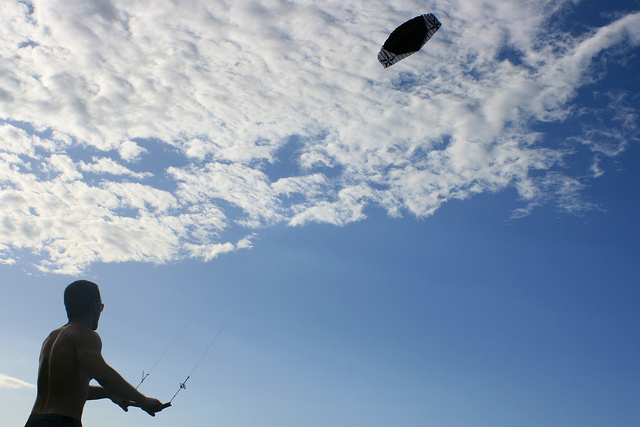

In [188]:
idx = random.randrange(0, len(captions))
img_path = captions.iloc[idx].image
#img_path = 'C:/Users/IDAC PC/Desktop/UtkuThesis/mt-utku-elagoez/src/IMG_3028.jpg'

predicted_caption = generate_caption(img_path,source_flag='path')
print('Predicted Caption:', generate_caption(img_path,source_flag='path'))
print()
Image.open(img_path)

In [185]:
idx = random.randrange(0, len(captions))
img_path = captions.iloc[idx].image
predicted_caption = generate_caption(img_path, add_noise=False)
print(predicted_caption)
Image.open(img_path)

TypeError: generate_caption() missing 1 required positional argument: 'source_flag'

In [ ]:
import tensorflow as tf
import os
import json
import pandas as pd
import re
import numpy as np
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm
from PIL import Image

from nltk.translate.bleu_score import corpus_bleu
from nltk.util import ngrams


from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction
from tqdm import tqdm

# Load your validation data (use captions from val_imgs)
val_data = val_imgs  # Replace with your validation data (image paths)

# Define the BLEU score tracking lists
references, hypotheses = list(), list()
smoother = SmoothingFunction()

for img_path in tqdm(val_data):
    # Get the actual caption from the DataFrame (assuming 'val_imgs' contains image paths)
    matching_rows = captions[captions['image'] == img_path]
    if not matching_rows.empty:
        actual_caption = matching_rows['caption'].values[0]
    else:
        actual_caption = ""  # Set a default value or handle it appropriately

    # Predict the caption for the image
    predicted_caption = generate_caption(img_path, add_noise=False)

    # Split actual caption into words
    actual_captions = actual_caption.split()

    # Split predicted caption into words
    predicted_captions = predicted_caption.split()

    # Append to the lists
    references.append([actual_captions])
    hypotheses.append(predicted_captions)

# Calculate BLEU scores
bleu_1 = corpus_bleu(references, hypotheses, weights=(1.0, 0, 0, 0), smoothing_function=smoother.method4)
bleu_2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0), smoothing_function=smoother.method4)
bleu_3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoother.method4)
bleu_4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoother.method4)

# Print BLEU scores
print("BLEU-1: %f" % bleu_1)
print("BLEU-2: %f" % bleu_2)
print("BLEU-3: %f" % bleu_3)
print("BLEU-4: %f" % bleu_4)

generate_caption()
generate_caption()
generate_caption()
generate_caption()
generate_caption()



In [ ]:
num_images_to_evaluate = 100  # You can adjust this number based on your validation set size
eval_img_paths = val_imgs[:num_images_to_evaluate]
generated_captions = [generate_caption(img_path) for img_path in eval_img_paths]

# Prepare reference captions
reference_captions = prepare_reference_captions(eval_img_paths)

# Create a Meteor object
meteor_obj = Meteor()

# Tokenize reference and generated captions
reference_captions = [[caption.lower()] for caption in reference_captions]
generated_captions = [caption.lower() for caption in generated_captions]

# Compute METEOR score
meteor_score, meteor_scores = meteor_obj.compute_score(reference_captions, generated_captions)
print(f'METEOR Score: {meteor_score}')

In [ ]:
from pythonrouge.pythonrouge import Pythonrouge
import nltk
from nltk.translate.meteor_score import meteor_score
from tqdm import tqdm
from nltk.util import ngrams

# ... (your existing code)

# Define the ROUGE and METEOR score tracking lists
references_rouge, hypotheses_rouge = list(), list()
references_meteor, hypotheses_meteor = list(), list()

# Define a SmoothingFunction for METEOR
smoothing_function = SmoothingFunction().method4

for img_path in tqdm(val_data):
    # Get the actual caption from the DataFrame (assuming 'val_imgs' contains image paths)
    matching_rows = df[df['image'] == img_path]
    if not matching_rows.empty:
        actual_caption = matching_rows['caption'].values[0]
    else:
        actual_caption = ""  # Set a default value or handle it appropriately

    # Predict the caption for the image
    predicted_caption = generate_caption(img_path, add_noise=False)

    # Split actual caption into words
    actual_captions = actual_caption.split()

    # Split predicted caption into words
    predicted_captions = predicted_caption.split()

    # Append to the lists for ROUGE
    references_rouge.append(actual_captions)
    hypotheses_rouge.append(predicted_captions)

    # Append to the lists for METEOR
    references_meteor.append(actual_caption)
    hypotheses_meteor.append(predicted_caption)

# Calculate ROUGE scores
rouge = Pythonrouge(summary_file_exist=False,
                    predict_sentences=hypotheses_rouge, reference_sentences=references_rouge,
                    n_gram=2, ROUGE_SU4=True, ROUGE_L=True)
score_rouge = rouge.calc_score()
rouge_2_fscore = score_rouge["ROUGE-2-F"]
rouge_l_fscore = score_rouge["ROUGE-L-F"]

# Print ROUGE scores
print("ROUGE-2 F-Score: %f" % rouge_2_fscore)
print("ROUGE-L F-Score: %f" % rouge_l_fscore)

# Calculate METEOR score
meteor_scores = [meteor_score(ref, hyp, smoothing_function=smoothing_function) for ref, hyp in zip(references_meteor, hypotheses_meteor)]
average_meteor = sum(meteor_scores) / len(meteor_scores)

# Print METEOR score
print("Average METEOR Score: %f" % average_meteor)


In [ ]:
from nltk.translate.bleu_score import sentence_bleu

# Function to preprocess generated captions
def preprocess_generated_caption(caption):
    caption = re.sub(r'\[start\]', '', caption)
    caption = re.sub(r'\[end\]', '', caption)
    return caption.strip()

# Evaluate BLEU for a single image and its ground truth captions
def evaluate_bleu(img_path, reference_captions):
    # Generate caption for the image
    generated_caption = generate_caption(img_path)
    
    # Preprocess the generated and reference captions
    generated_caption = preprocess_generated_caption(generated_caption)
    reference_captions = [preprocess(caption) for caption in reference_captions]
    
    # Calculate BLEU score
    bleu_score = sentence_bleu(reference_captions, generated_caption)
    
    return bleu_score

# Evaluate BLEU for all test images
average_bleu_score = 0.0
num_test_images = len(val_imgs)

for img_path in tqdm(val_imgs, desc="Evaluating BLEU"):
    reference_captions = img_to_cap_vector[img_path]
    bleu_score = evaluate_bleu(img_path, 
                              a)
    average_bleu_score += bleu_score

# Calculate the average BLEU score
average_bleu_score /= num_test_images

print(f'Average BLEU Score for all test images: {average_bleu_score}')


In [ ]:
import numpy as np
from tqdm import tqdm
from rouge_score import rouge_scorer

# ...

# Assuming 'vectorization' is a function that tokenizes a sentence
# Assuming 'valid_images' is a list of image paths for validation
# Assuming 'decode_and_resize' is a function that loads and preprocesses an image
# Assuming 'caption_model' is your caption generation model
# Assuming 'valid_data' is a dictionary containing ground truth captions for validation images

all_rouge_scores = []

for img_path in tqdm(val_imgs):
    sample_img = decode_and_resize(img_path)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)

    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    encoded_img = caption_model.encoder(img, training=False)

    decoded_caption = "<start>"
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start>", "")
    decoded_caption = decoded_caption.replace("<end>", "").strip()
    if img_path in valid_data:
        captions_list = valid_data[img_path]
        extracted_captions = [caption.split('<start>')[1].split('<end>')[0].strip() for caption in captions_list]
        reference = [' '.join(caption.split()) for caption in extracted_captions]  # The real captions
        candidate = ' '.join(decoded_caption.split())   # The predicted caption

        scorer = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)
        scores = scorer.score(candidate, reference[0])  # Assuming you are comparing to the first reference
        print("Rouge scores:", scores)

        all_rouge_scores.append(scores)

average_rouge_scores = {
    rouge_type: np.mean([score[rouge_type].fmeasure for score in all_rouge_scores])
    for rouge_type in ['rouge1']
}

print(average_rouge_scores)

In [ ]:
from nltk.translate.meteor_score import meteor_score

# Assuming actual and predicted are lists of lists containing captions for each sample
# Example:
# actual = [['reference1_sample1', 'reference2_sample1'], ['reference1_sample2', 'reference2_sample2']]
# predicted = ['predicted_sample1', 'predicted_sample2']

total_meteor_score = 0
meteor_scores = []

for i in range(len(actual)):
    # Calculate METEOR score
    meteor = meteor_score(actual[i], predicted[i])
    meteor_scores.append(meteor)
    total_meteor_score += meteor

# Calculate average METEOR score
avg_meteor_score = total_meteor_score / len(actual)

print('Average METEOR score:', avg_meteor_score)


In [ ]:
idx = random.randrange(0, len(captions))
img_path = captions.iloc[idx].image

pred_caption = generate_caption(img_path)
print('Predicted Caption:', pred_caption)
print()
Image.open(img_path)

In [ ]:
img_url = "https://www.brides.com/thmb/XXZPZ4KSVLajZFyNgjEy395dKOI=/750x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/33814_05-eb9a2e4cc91544c5b78cc623c3c56222.jpg"

im = Image.open(requests.get(img_url, stream=True).raw)
im = im.convert('RGB')
im.save('tmp.jpg')

pred_caption = generate_caption('tmp.jpg', add_noise=False)
print('Predicted Caption:', pred_caption)
print()
im

In [ ]:
caption_model.save_weights('model.h5')